<a href="https://colab.research.google.com/github/WhiteTeaDragon/SingularValues/blob/main/SimpleConvTT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.python.keras import regularizers
import numpy as np
import random as rn
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras.engine.input_spec import InputSpec
import six
import functools
from tensorflow.python.ops import nn, nn_ops

np.random.seed(1)   
rn.seed(1)   
tf.random.set_seed(1234)

### Проверка функции, превращающей тензорное разложение в ядро

In [2]:
def full_tt(K1, K2, K3):
    """Converts a TensorTrain into a regular tensor or matrix (tf.Tensor)."""
    res = K1
    K2_reshaped = tf.reshape(K2, (K2.shape[0], -1))
    res = tf.matmul(res, K2_reshaped)
    res = tf.reshape(res, (-1, K3.shape[0]))
    res = tf.matmul(res, K3)
    res = tf.reshape(res, (K1.shape[0],) + K2.shape[1:-1] + (K3.shape[-1],))
    num_dims = len(K2.shape[1:-1])
    return tf.transpose(res, list(range(1, num_dims + 1)) + [0, num_dims + 1])

def simple_full_tt(K1, K2, K3):
    kernel_shape = K2.shape[1:-1]
    filters_shape = (K1.shape[0], K3.shape[-1])
    res = np.zeros(kernel_shape + filters_shape)
    if len(kernel_shape) == 2:
        for a in range(kernel_shape[0]):
            for b in range(kernel_shape[1]):
                for i in range(filters_shape[0]):
                    for j in range(filters_shape[1]):
                        for alpha in range(K1.shape[1]):
                            for beta in range(K2.shape[-1]):
                                res[a, b, i, j] += K1[i, alpha] * K2[alpha, a, b, beta] * K3[beta, j]
    elif len(kernel_shape) == 3:
        for a in range(kernel_shape[0]):
            for b in range(kernel_shape[1]):
                for c in range(kernel_shape[2]):
                    for i in range(filters_shape[0]):
                        for j in range(filters_shape[1]):
                            for alpha in range(K1.shape[1]):
                                for beta in range(K2.shape[-1]):
                                    res[a, b, c, i, j] += K1[i, alpha] * K2[alpha, a, b, c, beta] * K3[beta, j]
    else:
        raise ValueError("Only for 2D and 3D images.")
    return res

In [3]:
def check_funcs(rank, kernel_shape, filter_shape):
    r1 = min(filter_shape[0], rank)
    r2 = min(filter_shape[1], rank)
    K1 = np.random.rand(*(filter_shape[0], r1))
    K2 = np.random.rand(*((r1,) + kernel_shape + (r2,)))
    K3 = np.random.rand(*(r2, filter_shape[1]))
    clever_wrong = full_tt(K1, K2, K3)
    simple_right = simple_full_tt(K1, K2, K3)
    return np.allclose(clever_wrong, simple_right)

In [4]:
check_funcs(2, (2, 2), (2, 2))

True

In [5]:
check_funcs(2, (2, 2, 1), (2, 2))

True

In [6]:
check_funcs(2, (2, 2, 2), (2, 2))

True

In [7]:
check_funcs(4, (7, 7), (32, 32))

True

In [8]:
check_funcs(4, (7, 7, 7), (32, 32))

True

In [9]:
check_funcs(4, (7, 7), (16, 32))

True

In [10]:
check_funcs(4, (5, 5, 5), (16, 32))

True

In [11]:
check_funcs(2, (2, 1), (2, 2))

True

In [12]:
check_funcs(2, (2, 1), (1, 2))

True

In [13]:
check_funcs(2, (2, 2), (1, 2))

True

In [14]:
check_funcs(2, (2, 2), (2, 1))

True

In [15]:
check_funcs(17, (7, 7), (16, 32))

True

### Свёрточный 2D слой с ТТ-разложением

In [16]:
class ConvDecomposed2D(tf.keras.layers.Conv2D):
    def __init__(self,
               filters,
               kernel_size,
               decomposition_rank,
               strides=(1, 1),
               padding='valid',
               data_format=None,
               dilation_rate=(1, 1),
               activation=None,
               use_bias=True,
               kernel_initializer='glorot_uniform',
               bias_initializer='zeros',
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               **kwargs):
        super(ConvDecomposed2D, self).__init__(
               filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               padding=padding,
               data_format=data_format,
               dilation_rate=dilation_rate,
               groups=1, # does not support groups!
               activation=activation,
               use_bias=use_bias,
               kernel_initializer=kernel_initializer,
               bias_initializer=bias_initializer,
               kernel_regularizer=kernel_regularizer,
               bias_regularizer=bias_regularizer,
               activity_regularizer=activity_regularizer,
               kernel_constraint=kernel_constraint,
               bias_constraint=bias_constraint,
               **kwargs)
        self.decomposition_rank = decomposition_rank
        self.K1 = None
        self.K2 = None
        self.K3 = None
        self.bias = None
        self._convolution_op = None

    def build(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape)
        input_channel = self._get_input_channel(input_shape)
        kernel_shape = self.kernel_size + (input_channel, self.filters)
        r1 = min(input_channel, self.decomposition_rank)
        r2 = min(self.filters, self.decomposition_rank)
    
        self.K1 = self.add_weight(
            name='K1',
            shape=(input_channel, r1),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            trainable=True,
            dtype=self.dtype)
        self.K2 = self.add_weight(
            name='K2',
            shape=(r1,) + self.kernel_size + (r2,),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            trainable=True,
            dtype=self.dtype)
        self.K3 = self.add_weight(
            name='K3',
            shape=(r2, self.filters),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            trainable=True,
            dtype=self.dtype)
        
        # the rest is copied from Conv build function
        if self.use_bias:
            self.bias = self.add_weight(
              name='bias',
              shape=(self.filters,),
              initializer=self.bias_initializer,
              regularizer=self.bias_regularizer,
              constraint=self.bias_constraint,
              trainable=True,
              dtype=self.dtype)
        else:
            self.bias = None
        channel_axis = self._get_channel_axis()
        self.input_spec = InputSpec(min_ndim=self.rank + 2,
                                    axes={channel_axis: input_channel})
    
        # Convert Keras formats to TF native formats.
        if self.padding == 'causal':
            tf_padding = 'VALID'  # Causal padding handled in `call`.
        elif isinstance(self.padding, six.string_types):
            tf_padding = self.padding.upper()
        else:
            tf_padding = self.padding
        tf_dilations = list(self.dilation_rate)
        tf_strides = list(self.strides)
    
        tf_op_name = self.__class__.__name__
        if tf_op_name == 'Conv1D':
            tf_op_name = 'conv1d'  # Backwards compat.
    
        self._convolution_op = functools.partial(
            nn_ops.convolution_v2,
            strides=tf_strides,
            padding=tf_padding,
            dilations=tf_dilations,
            data_format=self._tf_data_format,
            name=tf_op_name)
        self.built = True

    def call(self, inputs):
        outputs = self._convolution_op(inputs, full_tt(self.K1, self.K2, self.K3))
        if self.use_bias:
            output_rank = outputs.shape.rank
            if self.rank == 1 and self._channels_first:
                # nn.bias_add does not accept a 1D input tensor.
                bias = array_ops.reshape(self.bias, (1, self.filters, 1))
                outputs += bias
            else:
                # Handle multiple batch dimensions.
                if output_rank is not None and output_rank > 2 + self.rank:
    
                    def _apply_fn(o):
                        return nn.bias_add(o, self.bias, data_format=self._tf_data_format)
    
                    outputs = nn_ops.squeeze_batch_dims(
                      outputs, _apply_fn, inner_rank=self.rank + 1)
                else:
                    outputs = nn.bias_add(
                      outputs, self.bias, data_format=self._tf_data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs        

### Проверка работоспособности слоя на наборе данных из букв (одна из наших домашек)

#### Подготовка данных

In [17]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_large.tar.gz
!tar -xvf notMNIST_large.tar.gz >> /dev/null

--2021-05-04 15:36:40--  http://yaroslavvb.com/upload/notMNIST/notMNIST_large.tar.gz
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247336696 (236M) [application/x-gzip]
Saving to: ‘notMNIST_large.tar.gz’

notMNIST_large.tar. 100%[===================>] 235.88M  25.8MB/s    in 9.9s    

2021-05-04 15:36:50 (23.9 MB/s) - ‘notMNIST_large.tar.gz’ saved [247336696/247336696]



In [18]:
DATA_DIR = 'notMNIST_large/'

In [19]:
from glob import glob
from PIL import Image
import os

for img_path in glob(f'{DATA_DIR}/**/*.png'):
  try:
    img = Image.open(img_path)
  except:
      os.remove(img_path)

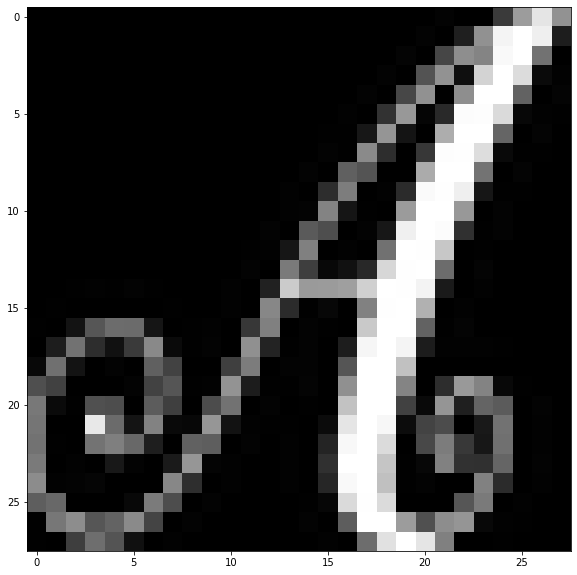

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(17,10))
letter = 'A'
img = cv2.imread(os.path.join(DATA_DIR, letter, os.listdir(f'{DATA_DIR}/{letter}/')[1]))
plt.imshow(img)

In [38]:
import os
import keras
from keras.models import Sequential
from keras.preprocessing import image
from keras.layers.core import Activation, Reshape, Dense, Flatten
from keras.layers import Conv2D, MaxPool2D, InputLayer, BatchNormalization, Dropout, GlobalAveragePooling2D, GlobalMaxPool2D
from keras.models import Model

pic_size = 28
n_classes = len(os.listdir(DATA_DIR))

def build_model(decomposition_rank):
    model = keras.Sequential([
        ConvDecomposed2D(32, 3, decomposition_rank=decomposition_rank,
                        input_shape=(pic_size, pic_size, 3),
                            data_format="channels_last", activation='relu',
                            padding='same'),
        keras.layers.MaxPooling2D(),
        ConvDecomposed2D(32, 3, decomposition_rank=decomposition_rank,
                        activation='relu', padding='same'),
        keras.layers.MaxPooling2D(),
        ConvDecomposed2D(16, 3, decomposition_rank=decomposition_rank,
                        activation='relu', padding='same'),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy'])
    model.summary()
    return model

In [39]:
from keras.preprocessing.image import ImageDataGenerator

# Подсказка: train/val split удобно делать вот так https://stackoverflow.com/questions/53037510/can-flow-from-directory-get-train-and-validation-data-from-the-same-directory-in (самый залайканый ответ)

""" Data generators initialization: for train and validation sets """
generator = ImageDataGenerator(validation_split=0.1, rescale=1./255)
train_gen = generator.flow_from_directory(DATA_DIR,
                                          target_size=(pic_size, pic_size),
                                          class_mode='categorical',
                                          subset='training', seed=1)
val_gen = generator.flow_from_directory(DATA_DIR,
                                        target_size=(pic_size, pic_size),
                                        class_mode='categorical',
                                        subset='validation', seed=1)

Found 476205 images belonging to 10 classes.
Found 52909 images belonging to 10 classes.


#### Модель с обычными свёрточными слоями

In [40]:
model = keras.Sequential([
    keras.layers.Conv2D(32, 3, input_shape=(pic_size, pic_size, 3),
                        data_format="channels_last", activation='relu',
                        padding='same'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(n_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 144)               0

In [41]:
step_size_train = (train_gen.n // train_gen.batch_size)
step_size_valid = (val_gen.n // val_gen.batch_size)

history2 = model.fit(train_gen, steps_per_epoch=step_size_train, epochs=2,
                    validation_data=val_gen,
                    validation_steps=step_size_valid)

Epoch 1/2
14881/14881 [==============================] - 241s 14ms/step - loss: 0.4431 - accuracy: 0.8683 - val_loss: 0.2580 - val_accuracy: 0.9219
Epoch 2/2
14881/14881 [==============================] - 211s 14ms/step - loss: 0.2789 - accuracy: 0.9142 - val_loss: 0.2227 - val_accuracy: 0.9320


#### decomposition_rank = 1

In [42]:
model1 = build_model(1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_decomposed2d (ConvDecom (None, 28, 28, 32)        76        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv_decomposed2d_1 (ConvDec (None, 14, 14, 32)        105       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv_decomposed2d_2 (ConvDec (None, 7, 7, 16)          73        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 144)              

In [43]:
step_size_train = (train_gen.n // train_gen.batch_size)
step_size_valid = (val_gen.n // val_gen.batch_size)

history2 = model1.fit(train_gen, steps_per_epoch=step_size_train, epochs=2,
                    validation_data=val_gen,
                    validation_steps=step_size_valid)

Epoch 1/2
14881/14881 [==============================] - 217s 15ms/step - loss: 0.7571 - accuracy: 0.7752 - val_loss: 0.4924 - val_accuracy: 0.8481
Epoch 2/2
14881/14881 [==============================] - 214s 14ms/step - loss: 0.5480 - accuracy: 0.8313 - val_loss: 0.4640 - val_accuracy: 0.8572


#### decomposition_rank = 17

In [49]:
16 * 16 + 16 * 3 * 3 * 17 + 17 * 32 + 16 # bias

3264

In [47]:
model17 = build_model(17)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_decomposed2d_12 (ConvDe (None, 28, 28, 32)        1044      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv_decomposed2d_13 (ConvDe (None, 14, 14, 32)        3721      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv_decomposed2d_14 (ConvDe (None, 7, 7, 16)          3264      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 144)              

In [50]:
step_size_train = (train_gen.n // train_gen.batch_size)
step_size_valid = (val_gen.n // val_gen.batch_size)

history2 = model17.fit(train_gen, steps_per_epoch=step_size_train, epochs=2,
                    validation_data=val_gen,
                    validation_steps=step_size_valid)

Epoch 1/2
14881/14881 [==============================] - 219s 15ms/step - loss: 0.4837 - accuracy: 0.8556 - val_loss: 0.2614 - val_accuracy: 0.9200
Epoch 2/2
14881/14881 [==============================] - 217s 15ms/step - loss: 0.2989 - accuracy: 0.9088 - val_loss: 0.2391 - val_accuracy: 0.9281
